In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeClassifier

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import cross_val_score

In [3]:
df = pd.read_csv('oasis_longitudinal.csv')

In [4]:
df.shape

(373, 15)

In [5]:
df.head(5)

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [6]:
df.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


In [7]:
df.columns

Index(['Subject ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F', 'Hand',
       'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF'],
      dtype='object')

## Handling Missing Values

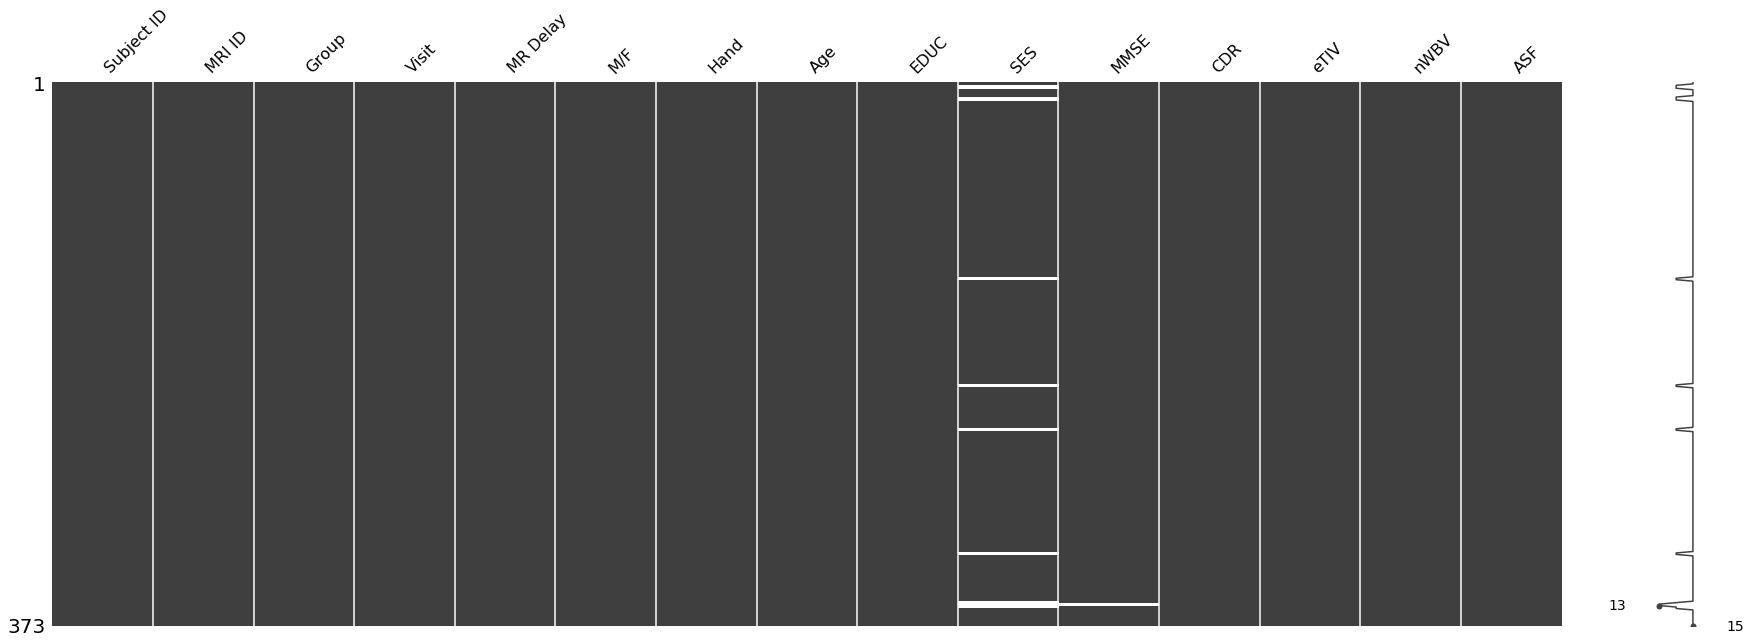

In [8]:
missingno.matrix(df, figsize = (30,10))

Very few missing values on SSE and MMSE. Hence we the row can be dropped.

In [9]:
df_new = df[df['MMSE'].notna()]

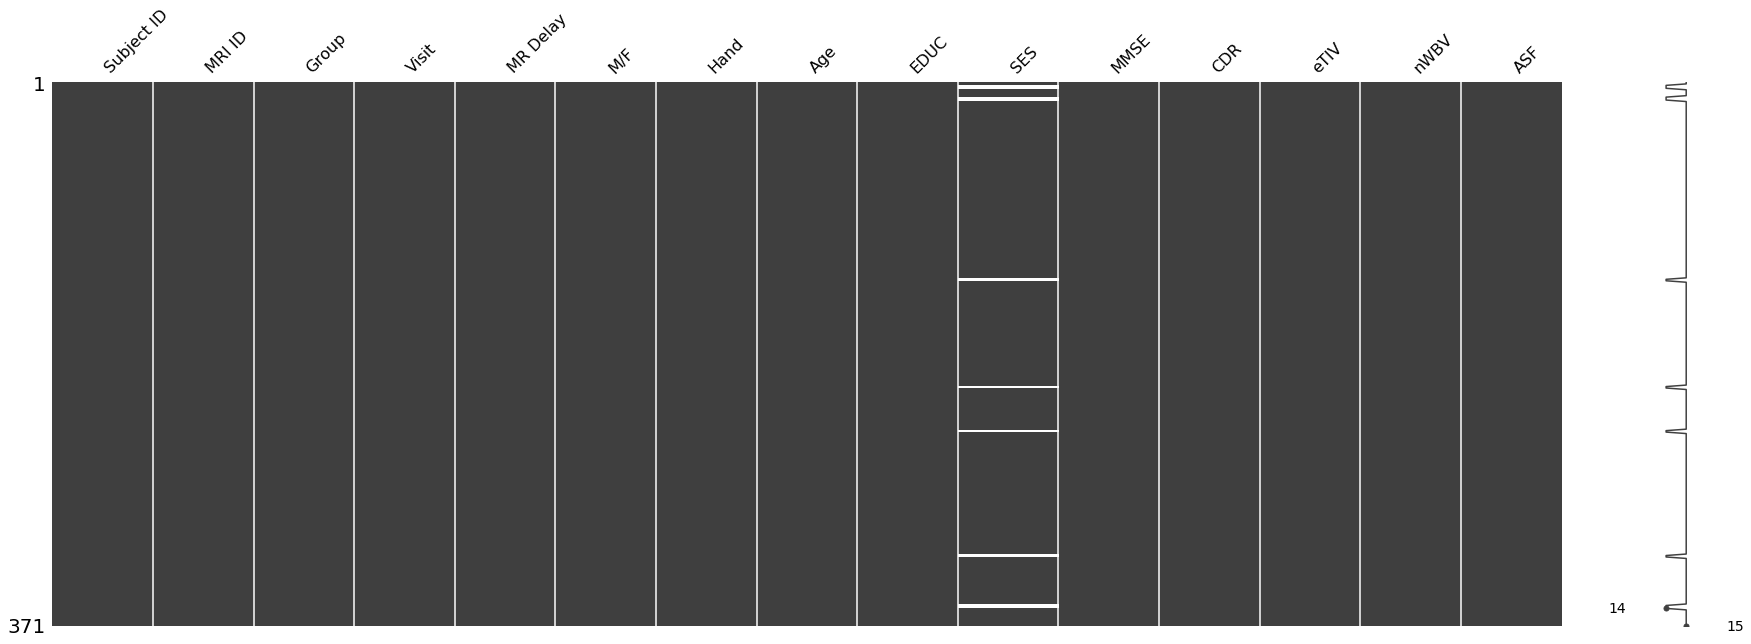

In [10]:
missingno.matrix(df_new, figsize = (30,10))

In [11]:
df_new["SES"].fillna(df_new.groupby("EDUC")["SES"].transform("median"), inplace=True)

In [12]:
# label encoding for gender
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_new['M/F'] = le.fit_transform(df_new['M/F'])

## Correlation Matrix

In [13]:
df_cor = df[df['MMSE'].notna()]
df_cor['Group'] = le.fit_transform(df_cor['Group'])

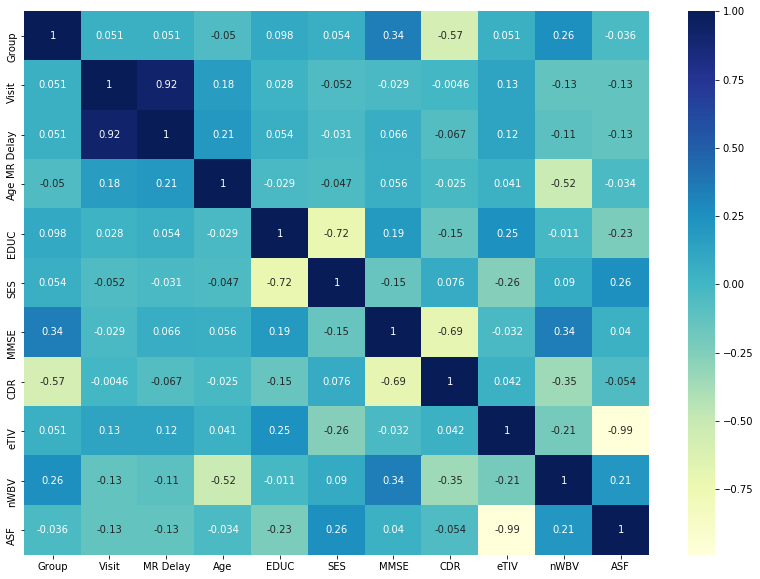

In [14]:
plt.figure(figsize=(14,10))
sns.heatmap(df_cor.corr(),annot=True,cmap="YlGnBu")

## Train and Test data

In [15]:
Y = df_new['Group'].values 
X = df_new[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']] # Features we use

# splitting into three sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, random_state=0)

# Feature scaling
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
best_score = 0
kfolds=5 

for md in range(1, 9): # iterate different maximum depth values
    # train the model
    treeModel = DecisionTreeClassifier(random_state=0, max_depth=md, criterion='gini')
    # perform cross-validation
    scores = cross_val_score(treeModel, X_train_scaled, Y_train, cv=kfolds, scoring='accuracy')
    
    # compute mean cross-validation accuracy
    score = np.mean(scores)
    
    # if we got a better score, store the score and parameters
    if score > best_score:
        best_score = score
        best_parameter = md

In [17]:
model = DecisionTreeClassifier(max_depth=best_parameter).fit(X_train_scaled, Y_train )
test_score = model.score(X_test_scaled, Y_test)
PredictedOutput = model.predict(X_test_scaled)
print("Best accuracy on validation set is:", best_score)

Best accuracy on validation set is: 0.7413636363636364


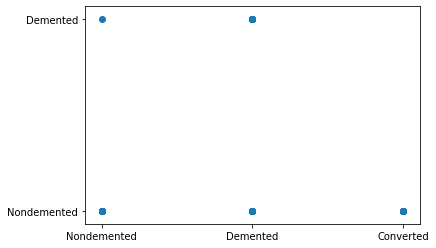

In [18]:
plt.scatter(Y_test, PredictedOutput)

In [19]:
import pickle
with open("Prediction.pickle", "wb")as f:
    pickle.dump(model, f)

In [20]:
df_new.head(10)

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,1,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,1,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,1,R,75,12,3.0,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,1,R,76,12,3.0,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,1,R,80,12,3.0,22.0,0.5,1698,0.701,1.034
5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,0,R,88,18,3.0,28.0,0.0,1215,0.710,1.444
6,OAS2_0004,OAS2_0004_MR2,Nondemented,2,538,0,R,90,18,3.0,27.0,0.0,1200,0.718,1.462
7,OAS2_0005,OAS2_0005_MR1,Nondemented,1,0,1,R,80,12,4.0,28.0,0.0,1689,0.712,1.039
8,OAS2_0005,OAS2_0005_MR2,Nondemented,2,1010,1,R,83,12,4.0,29.0,0.5,1701,0.711,1.032
9,OAS2_0005,OAS2_0005_MR3,Nondemented,3,1603,1,R,85,12,4.0,30.0,0.0,1699,0.705,1.033


In [21]:
model.predict([[1,84,14,2.0,27.0,1987,0.696,0.883]])

array(['Nondemented'], dtype=object)